<a href="https://colab.research.google.com/github/rosez/Springboard/blob/master/Capstone2Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone2 : Apparel Images


This project evaluates models to classify the Kaggle Apparel image dataset. Due to resource contraints on the initial implementation on local laptop, it uses 10 classes or the original 24 classes in the dataset.

The project uses a Convolutional Neural Network (CNN).

It allows the user to compare various models and configurations.

It is currently setup to run in a Google CoLab notebook.

We consider multiple models, of varying archetectures (ie., convolution/pool/dense layers and nodes). The models are defined in the module x10MakeModel section.  You specify a 'suffix' to indicate which model to use.

Run the project in the main.py section.  The first few sections are setup; the RunMe section allows for running subsets of models and parameters. It uses multiple lists, and will run all combinations of the list entries.



**LISTS:**

**suffixes**: 	model suffixes -- predefined models in the X10MakeModel section

**optnames**: 	list of (encoded) optimizers...they will be decoded in the 'xOptimizer' function.

**learning_rates**: learning rates (NOTE: since the learning rate varies by optimizer, will have to do a different call for each optimzer ...it might make more sense to convert this to a dictionary).


**pixels**: 	image size (square) in  pixels



**SAVED INFORMATION:**

For each model, it saves the following:

* the trained model parameters
* the model.fit() history
* plots for loss and accuracy progression during model trainung epochs, for the training and validation data


 
This project uses the Kaggle Apparel dataset


 



# Import tf to find out version



In [0]:
import tensorflow as tf


In [2]:
print(tf.__version__)

2.2.0


In [3]:
#tf.test.gpu_device_name()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun  2 14:25:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Connect to Google drive


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/My Drive/Capstone2/data/"

apparelSmallTest  apparelSmallTrain  apparelSmallValidate  capstone2.ipynb


# Moving on ...done with CoLab stuf

## Import modules



In [0]:
import os

import tensorflow as tf

import matplotlib.pyplot as plt
import math

 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler


# Function Definitions

## setPixels()

variables used  for image size

In [0]:
def setPixels(img_rows, img_cols, depth=3):
    # input image dimensions
    img_rows, img_cols = 150, 150
    input_shape = (img_rows, img_cols, depth)

    target_size = input_shape[:2]
    return (input_shape, target_size)



##xOptimizer


Decode optimizer name

In [0]:

def getOptimizer(optName, learning_rate, epochs):
    if optname == 'Adam':
        xoptimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optname == 'amsgrad':
        xoptimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
        
    if optname == 'Sgd':
        momentum = 0.8
        #epochs = 250
        decay_rate = learning_rate / epochs
        xoptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate)
    if optname =='sgdStep':
        momentum = 0.8
        xoptimizer = tf.keras.optimizers.SGD(learning_rate=0.0, momentum=momentum)
        
    return xoptimizer

 



## Data Generators

In [0]:
def dataGenerators(target_size):
    #!!import tensorflow as tf
    import keras_preprocessing
    from keras_preprocessing import image
    from keras_preprocessing.image import ImageDataGenerator
    
    TRAINING_DIR = trainingdir
    training_datagen = ImageDataGenerator(
          rescale = 1./255,
    	  rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
    
    
    VALIDATION_DIR = validdir
    validation_datagen = ImageDataGenerator(rescale = 1./255)

    
    train_generator = training_datagen.flow_from_directory(
    	TRAINING_DIR,
    	target_size=target_size,
        color_mode='rgb',
    	class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
    	VALIDATION_DIR,
    	target_size=target_size,
        color_mode='rgb',
    	class_mode='categorical'
    )

    
    return train_generator, validation_generator
    


def testDataGenerator(target_size):
    #!!import tensorflow as tf
    import keras_preprocessing
    from keras_preprocessing import image
    from keras_preprocessing.image import ImageDataGenerator
    
 
    TEST_DIR = testdir
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    
    test_generator = test_datagen.flow_from_directory(
    	TEST_DIR,
    	target_size=target_size,
        color_mode='rgb',
    	class_mode='categorical'
    )
    
    return test_generator


     

## Save Results
* pickle the history file
* plot and Save model history
* save the evaluation output


In [0]:


def pickleHist(history, filename):
    import pickle
 
    pfilename = filename + '.pkl'
    with open(pfilename, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)



def pickleEval(eval_output, filename):
    import pickle
 
    pfilename = filename + '.pkl'
    with open(pfilename, 'wb') as file_pi:
            pickle.dump(eval_output, file_pi)           
        
def plotModelHistory(history, suffix):
# Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model{0} accuracy'.format(suffix))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model{0} loss'.format(suffix))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def plotSaveModelHistory(history, saveInfo, history_path):
# Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model{0} accuracy'.format(saveInfo))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    
    savefile = history_path + 'Accuracy' + saveInfo + '.pdf'
    plt.savefig(savefile)
    plt.show()
 
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model{0} loss'.format(saveInfo))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    savefile = history_path + 'Loss' + saveInfo + '.pdf'
    plt.savefig(savefile)
    plt.show()
    

## x10MakeModel.py
Make model based on suffix parameter


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 17 12:29:25 2020

@author: rozoe
"""



def make_model(suffix, num_classes, input_shape):

#    num_classes, input_shape, learning_rate, epochs = getGlobalParms()
    if suffix==1:
        print('model1')
    
        model = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

 

    ################### model 2: add another conv/pool layer ################
    # del model2

    elif (suffix==2):
        print('model2')
 
        model2c = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model2c


################### model 3: the original overfitted model ################
    elif (suffix==3): 
        print('model3')
        

         
        model3 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model3
 


################### model 4: complex model inspired by asifbala (from Ankur) ################
    elif suffix==4:
 
        model4 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model4
 
    elif suffix==5:
 
################### model 5: pare down m4...too much memory ################
# two conv layers before pooling
        model5 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
     
        return model5
        
    elif suffix==6:
################### model 6: pare down m5, since it crashes the pc ################
# two conv layers before pooling

 
        model6 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model6
     
    elif suffix==7:
################### model 7: M4 + 2blocks  ################
# redo first model, but no pooling after first step 
# ...exceeds memory during make_model()
        model7 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fifth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The sizth convolution
            #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            #tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model7





 
# =============================================================================
#     elif suffix==10:
# 
#     ################### model 10: change the syntax to the viz format #############
#     # redo first model, but no pooling after first step
#         
#         from keras.models import Sequential
#         from keras.layers import Conv2D
#         from keras.layers import MaxPooling2D
#         from keras.layers import Flatten
#         from keras.layers import Dense
#         from keras.layers import Dropout
#         
#         classifier10 = Sequential()
#         #
#          
#         # Step 1 - Convolution
#         
#         classifier10.add(Conv2D(32, (3, 3), padding='same', input_shape = input_shape, activation = 'relu'))
#         classifier10.add(Conv2D(32, (3, 3), activation='relu'))
#         classifier10.add(MaxPooling2D(pool_size=(2, 2)))
#         classifier10.add(Dropout(0.5)) # antes era 0.25
#         # Adding a second convolutional layer
#         classifier10.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#         classifier10.add(Conv2D(64, (3, 3), activation='relu'))
#         classifier10.add(MaxPooling2D(pool_size=(2, 2)))
#         classifier10.add(Dropout(0.5)) # antes era 0.25
#         # Adding a third convolutional layer
#         ## classifier10.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#         ## classifier10.add(Conv2D(64, (3, 3), activation='relu'))
#         ## classifier10.add(MaxPooling2D(pool_size=(2, 2)))
#         ## classifier10.add(Dropout(0.5)) # antes era 0.25
#         # Step 3 - Flattening
#         classifier10.add(Flatten())
#         # Step 4 - Full connection
#         classifier10.add(Dense(units = 512, activation = 'relu'))
#         classifier10.add(Dropout(0.5)) 
#         classifier10.add(Dense(units = num_classes, activation = 'softmax'))
#         
#         classifier10.summary()
#         
#         classifier10.compile(optimizer = 'adam',
#                            loss = 'categorical_crossentropy', 
#                            metrics = ['accuracy'])
#         
#         histEx10Epoch1d10 = classifier10.fit_generator(train_generator,
#                                            steps_per_epoch = 100,
#                                            epochs = 10,
#         #                                  callbacks=[checkpointer],
#                                            validation_data = validation_generator,
#                                            validation_steps = 50)
#         return classifier10
# '''    
# 
# 
# =============================================================================
 
    elif suffix==8:
        print('model 8')
    ################### model 8: add additional block to model 7 ################
    # two conv layers before pooling
    #del model8
     
        model8 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fifth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The sizth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model8

 

 
    elif suffix==9:
        ################### model 9: model 6 * 2 num_channels ################
        # two conv layers before pooling
        
        #del model8
        model9 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model9
        
        ## model 9: waaay overfit...acc: .11 / .0786
    
    
    elif suffix==11:
        print('model11')
    
        model = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    
   
 
    elif suffix==12:
        ################### model 12: model 10 in keras################
        # two conv layers before pooling
        
 
        model12 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model12
        
        ## model 9: waaay overfit...acc: .11 / .0786
    
    
 
################### model 13: model 2 + 4*dense ################
 
    elif (suffix==13):
        print('model13')
 
        model13 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model13

        
    elif suffix==16:
        print('model' , suffix)
################### model 6: pare down m5, since it crashes the pc ################
# two conv layers before pooling


 
        model16 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model16

    elif suffix==101:
        # model 1 w/no dropout
        print('model101')
    
        model = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model



    else:
        print('did not find suffix')

    
################################ END MODEL DEFINITION #####################














## x20ProcessModel.py

compile and fit model 

==> return model and history object


In [0]:


def processModel(model, suffix, num_epochs, 
                 xoptimizer, 
                 train_generator, validation_generator,
                 batch_size,
                 callbacks=None):
    
    model.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer, metrics=['accuracy'])
    
    
    
    # calculate step sizes    
    #batch_size = 32
    steps_per_epoch = int(train_generator.samples / batch_size)
    validation_steps = int(validation_generator.samples / batch_size)
    test_steps = int(test_generator.samples / batch_size)
    
    
    #es = getEarlyStopping()
    ## notation epock1d20 ...epochs 1 dotdotdot 20 ==> 1 thru 20
    history  = model.fit(train_generator, epochs=num_epochs, 
                         validation_data = validation_generator,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         batch_size=batch_size,
                         verbose = 1, callbacks=callbacks)
    # plot History
    #plotModelHistory(history, suffix)

    return model, history




##formatLR()
Format the learning rate as a string for use in the saved information label names

In [0]:
 


def formatLR(lr):
    if lr == .001:
        return 'LR3'
    elif lr == .0001:
        return 'LR4'
    elif lr == 1e-05:
        return 'LR5'
    elif lr == 1e-06:
        return 'LR6'
    elif lr == 1e-07:
        return 'LR7'
    elif lr == 1e-08:
        return 'LR8'
    elif lr == .1:
        return 'LR1'
    elif lr == 0.01:
        return 'LR2'
    elif lr == 0.0005:
        return 'LR5e4'        
        
    else:
        return  'LR' + str(lr)


#formatLR(learning_rate)

# main.py

## Directory Paths

In [14]:
path = "/content/gdrive/My Drive/Capstone2/data/"
srcdir = path + 'apparel-images-dataset\\'

trainingdir = path + 'apparelSmallTrain'
testdir = path + 'apparelSmallTest'
validdir = path + 'apparelSmallValidate'
print(trainingdir)

/content/gdrive/My Drive/Capstone2/data/apparelSmallTrain


In [0]:

def getHistoryPath():
    #history_path = 'C:\\Users\\rozoe\\jy\\ch10ML\\tensorflow\\capstone2\\history\\'
    history_path = "/content/gdrive/My Drive/Capstone2/history/"
    return history_path  


## Parameters

In [16]:

# =============================================================================
# inLine Parameters
# =============================================================================

num_classes = 10
num_epochs = 250
epochs = num_epochs

#batch_size for model.fit
batch_size = 32  

print(num_classes,  num_epochs, batch_size)

10 250 32


## Callbacks


In [17]:
# =============================================================================
# Callbacks
# =============================================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8,
                   restore_best_weights=True)

# drop-based learning rate
#https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/

def step_decay(epoch):
	initial_lrate = 0.0005
	drop = 0.5
	epochs_drop = 10.0
	#epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

# learning ratee schedule callback
lrate = LearningRateScheduler(step_decay)

#Callbacks for using step decay learning rate scheduler
#callbacks = [es, lrate]

# Default callback for Early Stopping
callbacks = [es]

print(callbacks)
 


##RunMe

In [18]:
history_path = getHistoryPath()
print(history_path)

/content/gdrive/My Drive/Capstone2/history/


### Set parms for looping

NOTE: we do two sets of parms, since LR is depending on optimizer....ideally this should be a dictionary, but for now we are doing multiple runs.

In [19]:
# set parms for looping.

# all values
#optnames = ['Adam', 'amsgrad', 'Sgd', 'sgdStep']
suffixes = [1, 3, 6, 7, 8]



# RUN 1
optnames = ['amsgrad']
learning_rates = [.001,0.0001]
pixels = [150, 300]

 



# RUN 2 -- we limite the LRs and pixels based on RUN 1 results
#optnames = ['Sgd']
#learning_rates = [.01, .1]
#pixels = [150]

# SAMPLE RUN

suffixes = [1, 3]
optnames = ['amsgrad']
learning_rates = [.001]
pixels = [150]

print(optnames, learning_rates, suffixes, pixels)


['amsgrad'] [0.001] [1, 3] [150]


### Verify run list

In [20]:
# Verify run list before kicking off lengthy loop

for optname in optnames:
    for learning_rate in learning_rates:
        for suffix in suffixes:
            for pixel in pixels:
                #setPixels(pixel, pixel)
                lrFormatted = formatLR(learning_rate)


                # Label saved objects with model suffix and image size
                saveInfo = 'M' + str(suffix) + 'Pix' + str(pixel) + lrFormatted + optname
                print('SaveInfo: ', saveInfo)

SaveInfo:  M1Pix150LR3amsgrad
SaveInfo:  M3Pix150LR3amsgrad


### Loop through models: define, train, evaluate,  save results

In [22]:
# =============================================================================
# Run Models
# =============================================================================

 
for optname in optnames:
    for learning_rate in learning_rates:
        for suffix in suffixes:
            for pixel in pixels:

                input_shape, target_size = setPixels(pixel, pixel)
                lrFormatted = formatLR(learning_rate)

 
                # Label saved objects with model suffix and image size
                saveInfo = 'M' + str(suffix) + 'Pix' + str(pixel) + lrFormatted + optname
                print('SaveInfo: ', saveInfo)

                # get parm-specific details

                train_generator, validation_generator = dataGenerators(target_size)

                test_generator = testDataGenerator(target_size)

                xoptimizer = getOptimizer(optname, learning_rate, epochs) 



                # Define Model; the suffix indicates which model
                model = make_model(suffix, num_classes, input_shape)
                model.summary()

                # Compile and train model
                model, history = processModel(model, saveInfo, 250, 
                                            xoptimizer, 
                                            train_generator, validation_generator,
                                            batch_size,
                                            callbacks=callbacks)


                print('*** pickling history ***')
                pickleHist(history, history_path + 'history' + saveInfo)
                #pickleHist(history, history_path + 'historyLR1e4Epochs21d30Model' + str(suffix))


                print('*** plotting/saving history figures ***')
                # plot History
                #plotModelHistory(history, saveInfo)
                plotSaveModelHistory(history, saveInfo, history_path)

                print('*** evaluating Model ***')
                # Model Evaluation
                test_steps = int(test_generator.samples / batch_size)
                eval_output = model.evaluate(test_generator, steps=test_steps)         
                print(eval_output)

                # Save Evaluation information
                evalfile = history_path + 'eval' + saveInfo
                print(evalfile)
                #pickleEval(eval_output, history_path + 'eval' + str(suffix))
                pickleEval(eval_output, evalfile)

                print('*** saving model  ***')
                # Save the entire model as a SavedModel.
                savedmodeldir = '/content/gdrive/My Drive/Capstone2/saved_model/'

                #!mkdir -p savedmodeldir
                #!mkdir -p '/content/gdrive/My Drive/Capstone2/saved_model'
                modelpath =  savedmodeldir + 'model' + saveInfo
                model.save(modelpath)




SaveInfo:  M1Pix150LR3amsgrad
Found 5055 images belonging to 10 classes.
Found 1092 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
model1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dropout_1 (Dropout) 

KeyboardInterrupt: ignored

# Compare Model Results

Retrieve the information for the processed models, and compare results, using Holdout data accuracy as the metric.

## Setup parms

In [23]:
# all options
#optnames = ['Adam', 'amsgrad', 'Sgd', 'sgdStep']
learning_rates = [0.01, .001, .0001]
suffixes = [1, 3, 6, 7, 8]
pixels = [150, 300]

# use  a subset of options
optnames = ['Sgd','amsgrad']

print(optnames, learning_rates, suffixes, pixels)

history_path = getHistoryPath()

['Sgd', 'amsgrad'] [0.01, 0.001, 0.0001] [1, 3, 6, 7, 8] [150, 300]


### Create data frame to hold results

In [24]:
# Generate dataframe to hold results...will use for plotting

import pandas as pd

df_accuracy = pd.DataFrame({'optimizer': [], 'lr': [], 'pixels': []})

for optname in optnames:
    for learning_rate in learning_rates:
        for pixel in pixels:
            df_accuracy = df_accuracy.append(pd.Series([optname, learning_rate, pixel ],
                                                       index=df_accuracy.columns), 
                                             ignore_index=True)

xrows = len(df_accuracy)
xlist = [None] * len(df_accuracy)

for suffix in suffixes:
    model_name = 'M' + str(suffix)
    df_accuracy[model_name] = xlist

print(df_accuracy)


   optimizer      lr  pixels    M1    M3    M6    M7    M8
0        Sgd  0.0100   150.0  None  None  None  None  None
1        Sgd  0.0100   300.0  None  None  None  None  None
2        Sgd  0.0010   150.0  None  None  None  None  None
3        Sgd  0.0010   300.0  None  None  None  None  None
4        Sgd  0.0001   150.0  None  None  None  None  None
5        Sgd  0.0001   300.0  None  None  None  None  None
6    amsgrad  0.0100   150.0  None  None  None  None  None
7    amsgrad  0.0100   300.0  None  None  None  None  None
8    amsgrad  0.0010   150.0  None  None  None  None  None
9    amsgrad  0.0010   300.0  None  None  None  None  None
10   amsgrad  0.0001   150.0  None  None  None  None  None
11   amsgrad  0.0001   300.0  None  None  None  None  None


### Populate results table

In [25]:
# populate results table by retrieving evaluation information from pickled files

import pickle
import matplotlib.pyplot as plt

# loop through all combinations
for optname in optnames:
    for learning_rate in learning_rates:
        for suffix in suffixes:
            for pixel in pixels:
 
                lrFormatted = formatLR(learning_rate)
                model_name = 'M' + str(suffix)


                # generate Label format for saved objects with model suffix and image size
                saveInfo = model_name + 'Pix' + str(pixel) + lrFormatted + optname
                print('SaveInfo: ', saveInfo)

                # generate format used for Saved Evaluation information

                evalfile = history_path + 'eval' + saveInfo + '.pkl'
                print('EvalFile:', evalfile)
 

                try:
                    with open(evalfile, 'rb') as handle:
                        b = pickle.load(handle)
                except:
                    print('EXCEPTION: {0} does not exist '.format(evalfile))
                    break

                with open(evalfile, 'rb') as handle:
                    eval_info = pickle.load(handle)

                print('eval_info: ', eval_info)

                # update results table with accuracy for corresponding experiment  
                df_accuracy.loc[(df_accuracy['optimizer'] == optname) & 
                                (df_accuracy['lr'] == learning_rate) & 
                                (df_accuracy['pixels'] == pixel),
                                model_name] = eval_info[1]

 


SaveInfo:  M1Pix150LR2Sgd
EvalFile: /content/gdrive/My Drive/Capstone2/history/evalM1Pix150LR2Sgd.pkl
eval_info:  [0.31547391414642334, 0.8878676295280457]
SaveInfo:  M1Pix300LR2Sgd
EvalFile: /content/gdrive/My Drive/Capstone2/history/evalM1Pix300LR2Sgd.pkl
EXCEPTION: /content/gdrive/My Drive/Capstone2/history/evalM1Pix300LR2Sgd.pkl does not exist 
SaveInfo:  M3Pix150LR2Sgd
EvalFile: /content/gdrive/My Drive/Capstone2/history/evalM3Pix150LR2Sgd.pkl
eval_info:  [0.20603372156620026, 0.9227941036224365]
SaveInfo:  M3Pix300LR2Sgd
EvalFile: /content/gdrive/My Drive/Capstone2/history/evalM3Pix300LR2Sgd.pkl
EXCEPTION: /content/gdrive/My Drive/Capstone2/history/evalM3Pix300LR2Sgd.pkl does not exist 
SaveInfo:  M6Pix150LR2Sgd
EvalFile: /content/gdrive/My Drive/Capstone2/history/evalM6Pix150LR2Sgd.pkl
eval_info:  [0.3256545662879944, 0.8795955777168274]
SaveInfo:  M6Pix300LR2Sgd
EvalFile: /content/gdrive/My Drive/Capstone2/history/evalM6Pix300LR2Sgd.pkl
EXCEPTION: /content/gdrive/My Drive/Capst

### Print results table

In [26]:
# print results table to show which combinations we actually ran...
print(df_accuracy)

   optimizer      lr  pixels        M1        M3        M6        M7        M8
0        Sgd  0.0100   150.0  0.887868  0.922794  0.879596  0.944853  0.942096
1        Sgd  0.0100   300.0      None      None      None      None  0.935662
2        Sgd  0.0010   150.0      None      None      None      None      None
3        Sgd  0.0010   300.0      None      None      None      None      None
4        Sgd  0.0001   150.0      None      None      None      None      None
5        Sgd  0.0001   300.0      None      None      None      None      None
6    amsgrad  0.0100   150.0      None      None      None      None      None
7    amsgrad  0.0100   300.0      None      None      None      None      None
8    amsgrad  0.0010   150.0  0.918199  0.954044   0.92739  0.944853  0.951287
9    amsgrad  0.0010   300.0  0.909007  0.940257  0.908088  0.943015  0.933824
10   amsgrad  0.0001   150.0      None  0.929228      None  0.943015      None
11   amsgrad  0.0001   300.0      None      None    

## Make Plots

### Plot: Accuracy for Optimizer vs model

df_filtered 
   optimizer        M1        M3        M6        M7        M8
0       Sgd  0.887868  0.922794  0.879596  0.944853  0.942096
8   amsgrad  0.918199  0.954044   0.92739  0.944853  0.951287
melted 
   optimizer model  accuracy
0       Sgd    M1  0.887868
1   amsgrad    M1  0.918199
2       Sgd    M3  0.922794
3   amsgrad    M3  0.954044
4       Sgd    M6  0.879596
5   amsgrad    M6   0.92739
6       Sgd    M7  0.944853
7   amsgrad    M7  0.944853
8       Sgd    M8  0.942096
9   amsgrad    M8  0.951287


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Holdout Accuracy by Model and Optimizer')

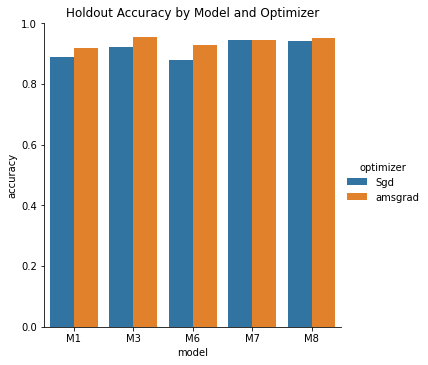

In [27]:
# plot optimizer vs model for pixels = 150 (and best lr/optimizer)

df = df_accuracy
#df_filtered = pd.DataFrame(df.loc[(df.pixels==150)]  )


df_filtered = pd.DataFrame( df.loc[(((df.optimizer=='amsgrad') & (df.lr == .0010)) |
                      ((df.optimizer == 'Sgd') & (df.lr == .01))) &
                      (df.pixels == 150)
                      ]) [['optimizer','M1','M3','M6','M7','M8']]



print('df_filtered \n', df_filtered)


melted = pd.melt(df_filtered, id_vars='optimizer', var_name='model',value_name='accuracy')
print('melted \n', melted)

import seaborn as sns
sns.catplot(x="model", y="accuracy", hue="optimizer", kind="bar", data=melted);

plt.title('Holdout Accuracy by Model and Optimizer')

==> Amsgrad is better (or the same) than Sgd for all models in this case. 

*Therefore, we use Amsgrad results for subsequent analysis*

### Plot: Accuracy vs Image Size

  optimizer     lr  pixels        M1        M3        M6        M7        M8
8   amsgrad  0.001   150.0  0.918199  0.954044   0.92739  0.944853  0.951287
9   amsgrad  0.001   300.0  0.909007  0.940257  0.908088  0.943015  0.933824


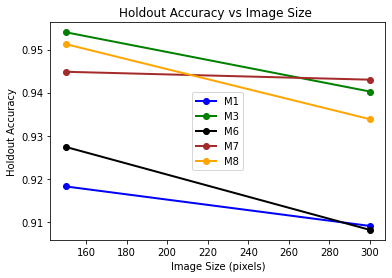

In [28]:
# Plot accuracy vs image size (optimizer = Amsgrad)

#rename data frame for more efficient typing
df = df_accuracy
df_filtered = pd.DataFrame(df.loc[(df.optimizer=='amsgrad') & (df.lr == .0010)])

print(df_filtered)
 
# multiple line plot
#plt.plot( 'pixels', 'M1', data=df_filtered, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'pixels', 'M1', data=df_filtered, marker='o', markerfacecolor='blue', markersize=None, color='blue', linewidth=2)
plt.plot( 'pixels', 'M3', data=df_filtered, marker='o', color='green', linewidth=2)
plt.plot( 'pixels', 'M6', data=df_filtered, marker='o', color='black', linewidth=2, linestyle='solid' )
plt.plot( 'pixels', 'M7', data=df_filtered, marker='o', color='brown', linewidth=2, linestyle='solid' )
plt.plot( 'pixels', 'M8', data=df_filtered, marker='o', color='orange', linewidth=2, linestyle='solid')
#plt.plot( 'pixels', 'M8', data=df_filtered, marker='', color='orange', linewidth=2, linestyle='dashed', label="toto")

plt.title('Holdout Accuracy vs Image Size ')
plt.xlabel('Image Size (pixels)')
plt.ylabel('Holdout Accuracy')
plt.legend()




==> Accuracy is better for the smaller image size

### Plot: Accuracy vs Learning Rate

   optimizer      lr  pixels        M1        M3       M6        M7        M8
6    amsgrad  0.0100   150.0      None      None     None      None      None
8    amsgrad  0.0010   150.0  0.918199  0.954044  0.92739  0.944853  0.951287
10   amsgrad  0.0001   150.0      None  0.929228     None  0.943015      None


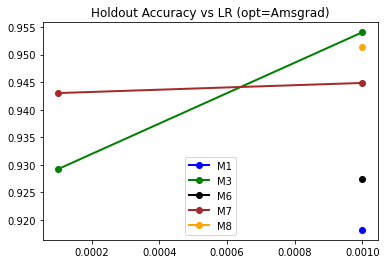

In [29]:
# Plot accuracy vs learning rate (optimizer = Amsgrad)

df = df_accuracy
df_filtered = pd.DataFrame(df.loc[(df.optimizer=='amsgrad') & (df.pixels==150)])

print(df_filtered)
xval = 'lr'

# multiple line plot
plt.plot( xval, 'M1', data=df_filtered, marker='o', markerfacecolor='blue', markersize=None, color='blue', linewidth=2)
plt.plot( xval, 'M3', data=df_filtered, marker='o', color='green', linewidth=2)
plt.plot( xval, 'M6', data=df_filtered, marker='o', color='black', linewidth=2, linestyle='solid' )
plt.plot( xval, 'M7', data=df_filtered, marker='o', color='brown', linewidth=2, linestyle='solid' )
plt.plot( xval, 'M8', data=df_filtered, marker='o', color='orange', linewidth=2, linestyle='solid')
#plt.plot( xval, 'M8', data=df_filtered, marker='', color='orange', linewidth=2, linestyle='dashed', label="toto")

plt.legend(loc='lower center')
plt.title('Holdout Accuracy vs LR (opt=Amsgrad)')
plt.xlabel = ('Learning Rate')
plt.ylabel = ('Holdout Accuracy')



==>  the lower learning rate of 1e-4 (.0001) is worse than 1e-3 (.001)

# Best Model -- Todo

* Confusion Matrix
* Example of mis-Classified images